This validation is not described in detail in the thesis. It is also not as meaningful by far as the *leave-one-protein-out cross-validation*.

Intention of this notebook is to evaluate the most relevant models trained on the T1626 dataset (also filtered) on the prospective T96 dataset.

Additionally, it is investigated how nowledge about examplary mutations on the target wild-type protein affects performance. (However, data on protein is heavily biased, so the results may just show that the model learns the bias in the dataset)

For current nomenclature refer to the model names in brackets.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc
import matplotlib.pyplot as plt
import pickle as pkl
import pylab
import random
import seaborn as sns

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T96/cnn_rep_sampler_T96/"
base_data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T96/paper_datasets_T96/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Validation_Models/"
fig_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Prospective_T96/"
T1626_base_data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/paper_datasets_T1626/"

y_target_loc = base_data_folder_loc + "y_label_xgboost_T96.csv"
X_paper_loc =  base_data_folder_loc + "X_paper_xgboost_T96.csv"

y_T1626_target_loc = T1626_base_data_folder_loc + "y_label_xgboost_T1626.csv"
X_T1626_paper_loc = T1626_base_data_folder_loc + "X_paper_xgboost_T1626.csv"

X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"

model_seq_rep_loc = model_folder_loc + "model_cnn_all_01_02_03_xgboost_T1626.pkl"
model_seq_rep_filtered_loc = model_folder_loc + "model_cnn_all_01_02_03_xgboost_T1626_filtered.pkl"
model_paper_loc = model_folder_loc + "model_paper_xgboost_T1626.pkl"
model_paper_filtered_loc = model_folder_loc + "model_paper_xgboost_T1626_filtered.pkl"
model_combined_loc = model_folder_loc + "model_paper_cnn_01_02_03_all_xgboost_T1626.pkl"
model_combined_filtered_loc = model_folder_loc + "model_paper_cnn_01_02_03_all_xgboost_T1626_filtered.pkl"

parameter_table_paper_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Paper_Features_Own_Baseline/results_paper_own_baseline_xgboost_T1626.pkl"

merck_and_co_excel_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/Source/merck_and_co.xls"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(base_data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("\t",os.path.isdir(fig_loc))
print("\t",os.path.isdir(T1626_base_data_folder_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_paper_loc))
print("\t",os.path.isfile(model_seq_rep_loc))
print("\t",os.path.isfile(model_seq_rep_filtered_loc))
print("\t",os.path.isfile(model_paper_loc))
print("\t",os.path.isfile(model_paper_filtered_loc))
print("\t",os.path.isfile(model_combined_loc))
print("\t",os.path.isfile(model_combined_filtered_loc))
print("\t",os.path.isfile(parameter_table_paper_loc))
print("\t",os.path.isfile(merck_and_co_excel_loc))

Folders: 
	 True
	 True
	 True
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

     |████████████████████████████████| 114.0MB 288kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


## Prepare Data

In [0]:
#Just load data
y_label = pd.read_csv(y_target_loc)["dtm"].values 

X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_all_01.columns = list(map(lambda x: "layer_01_"+x, X_seq_all_01.columns))
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_all_02.columns = list(map(lambda x: "layer_02_"+x, X_seq_all_02.columns))
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_all_03.columns = list(map(lambda x: "layer_03_"+x, X_seq_all_03.columns))

X_paper = pd.read_csv(X_paper_loc) 

with open(model_seq_rep_loc, 'rb') as handle:
  model_seq_rep = pkl.load(handle)
with open(model_seq_rep_filtered_loc, 'rb') as handle:
  model_seq_rep_filtered = pkl.load(handle)
with open(model_paper_loc, 'rb') as handle:
  model_paper = pkl.load(handle)
with open(model_paper_filtered_loc, 'rb') as handle:
  model_paper_filtered = pkl.load(handle)
with open(model_combined_loc, 'rb') as handle:
  model_combined = pkl.load(handle)
with open(model_combined_filtered_loc, 'rb') as handle:
  model_combined_filtered = pkl.load(handle)

parameter_table_paper = pd.read_pickle(parameter_table_paper_loc)
y_T1626 = pd.read_csv(y_T1626_target_loc)["dtm"].values 
X_T1626 = pd.read_csv(X_T1626_paper_loc) 

T96_table = pd.read_excel(io=merck_and_co_excel_loc, sheet_name=2, header=0)

In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_all_01_02_03 = X_seq_all_01_02_03.reset_index(drop=True)

In [0]:
print(X_paper.shape)
print(X_seq_all_01_02_03.shape)

(96, 158)
(96, 5376)


In [0]:
X_paper_all_01_02_03 = pd.concat([X_seq_all_01_02_03, X_paper], axis=1)

In [0]:
print(X_paper_all_01_02_03.shape)
X_paper_all_01_02_03.head()

(96, 5534)


,layer_01_wt_rep_0,layer_01_wt_rep_1,layer_01_wt_rep_2,layer_01_wt_rep_3,layer_01_wt_rep_4,layer_01_wt_rep_5,layer_01_wt_rep_6,layer_01_wt_rep_7,layer_01_wt_rep_8,layer_01_wt_rep_9,layer_01_wt_rep_10,layer_01_wt_rep_11,layer_01_wt_rep_12,layer_01_wt_rep_13,layer_01_wt_rep_14,layer_01_wt_rep_15,layer_01_wt_rep_16,layer_01_wt_rep_17,layer_01_wt_rep_18,layer_01_wt_rep_19,layer_01_wt_rep_20,layer_01_wt_rep_21,layer_01_wt_rep_22,layer_01_wt_rep_23,layer_01_wt_rep_24,layer_01_wt_rep_25,layer_01_wt_rep_26,layer_01_wt_rep_27,layer_01_wt_rep_28,layer_01_wt_rep_29,layer_01_wt_rep_30,layer_01_wt_rep_31,layer_01_wt_rep_32,layer_01_wt_rep_33,layer_01_wt_rep_34,layer_01_wt_rep_35,layer_01_wt_rep_36,layer_01_wt_rep_37,layer_01_wt_rep_38,layer_01_wt_rep_39,...,mono_fa_intra_rep,mono_fa_pair,mono_fa_rep,mono_fa_sol,mono_hbond_bb_sc,mono_hbond_lr_bb,mono_hbond_sc,mono_hbond_sr_bb,mono_omega,mono_p_aa_pp,mono_pro_close,mono_rama,mono_ref,mutability_diff,mutability_first,mutability_second,pi_diff,pi_first,pi_second,polarity2_diff,polarity2_first,polarity2_second,polarity_diff,polarity_first,polarity_second,r_bioluminate_delta_stability,r_bioluminate_delta_stability_coulomb,r_bioluminate_delta_stability_covalent,r_bioluminate_delta_stability_hbond,r_bioluminate_delta_stability_lipo,r_bioluminate_delta_stability_packing,r_bioluminate_delta_stability_reference,r_bioluminate_delta_stability_selfcont,r_bioluminate_delta_stability_solv_gb,r_bioluminate_delta_stability_solv_sa,r_bioluminate_delta_stability_vdw,totalarea,vdw_vol_diff,vdw_vol_first,vdw_vol_second
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140031,0.0,...,0.049,0.626,5.920,3.543,-1.805,-0.041,1.975,-0.053,1.060,-0.088,0.141,0.441,0.75,-82,100,18,-0.22,6.11,5.89,-2.7,8.1,5.4,2.10,0.0,2.10,464.745667,-0.462229,170.267661,0.151277,-23.082753,-1.820343e-08,9.17,0.000000,4.570107,0,304.131604,236.879,61.1,13.7,74.8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140031,0.0,...,0.007,0.543,-0.137,-1.569,-1.191,-0.005,-0.442,0.101,0.107,0.418,0.048,0.374,0.02,-50,106,56,6.82,2.77,9.59,-1.7,13.0,11.3,-0.20,49.7,49.50,-20.713759,23.304557,-0.464403,0.615041,6.015998,0.000000e+00,-30.85,0.000000,-18.190622,0,-1.144330,280.015,31.5,30.0,61.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140031,0.0,...,-0.007,0.734,1.358,-5.339,-1.267,0.065,1.592,0.022,-0.170,0.259,0.058,0.274,0.57,-66,106,40,3.21,2.77,5.98,-8.1,13.0,4.9,-49.57,49.7,0.13,-25.069801,21.644301,3.894196,1.346660,-9.577375,0.000000e+00,-48.15,0.000000,8.028257,0,-2.255839,280.015,14.4,30.0,44.4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140031,0.0,...,-0.004,0.562,0.482,1.955,-1.476,-0.169,0.550,-0.078,0.119,0.124,0.082,0.043,-0.31,-41,106,65,8.38,2.77,11.15,-2.5,13.0,10.5,2.30,49.7,52.00,-30.009160,48.500684,5.879602,1.069529,-9.748671,-1.223739e-01,-16.18,0.000000,-54.952045,0,-4.455884,280.015,47.3,30.0,77.3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140031,0.0,...,-0.003,0.121,0.328,-3.252,-0.076,-0.068,-0.331,0.086,-0.112,0.035,0.007,-0.066,0.30,14,106,120,2.91,2.77,5.68,-3.8,13.0,9.2,-48.03,49.7,1.67,-1.315987,30.514943,8.258627,0.561688,-0.010496,0.000000e+00,-40.42,-3.628232,2.610974,0,0.796509,204.903,-11.7,30.0,18.3


In [0]:
str(list(X_paper_all_01_02_03.columns))

"['layer_01_wt_rep_0', 'layer_01_wt_rep_1', 'layer_01_wt_rep_2', 'layer_01_wt_rep_3', 'layer_01_wt_rep_4', 'layer_01_wt_rep_5', 'layer_01_wt_rep_6', 'layer_01_wt_rep_7', 'layer_01_wt_rep_8', 'layer_01_wt_rep_9', 'layer_01_wt_rep_10', 'layer_01_wt_rep_11', 'layer_01_wt_rep_12', 'layer_01_wt_rep_13', 'layer_01_wt_rep_14', 'layer_01_wt_rep_15', 'layer_01_wt_rep_16', 'layer_01_wt_rep_17', 'layer_01_wt_rep_18', 'layer_01_wt_rep_19', 'layer_01_wt_rep_20', 'layer_01_wt_rep_21', 'layer_01_wt_rep_22', 'layer_01_wt_rep_23', 'layer_01_wt_rep_24', 'layer_01_wt_rep_25', 'layer_01_wt_rep_26', 'layer_01_wt_rep_27', 'layer_01_wt_rep_28', 'layer_01_wt_rep_29', 'layer_01_wt_rep_30', 'layer_01_wt_rep_31', 'layer_01_wt_rep_32', 'layer_01_wt_rep_33', 'layer_01_wt_rep_34', 'layer_01_wt_rep_35', 'layer_01_wt_rep_36', 'layer_01_wt_rep_37', 'layer_01_wt_rep_38', 'layer_01_wt_rep_39', 'layer_01_wt_rep_40', 'layer_01_wt_rep_41', 'layer_01_wt_rep_42', 'layer_01_wt_rep_43', 'layer_01_wt_rep_44', 'layer_01_wt_rep_4

## Supplementary functions


In [0]:
def plot_hist_label(y_label, x1, y1, title, save_loc):
    sns.set()
    pylab.rc('font', family="Sans", size=16)
    fig, ax = plt.subplots(1, 1, figsize=(7,6.5))
    y_label.plot(kind="hist",title=title, color=["lightslategray"], grid=True, fontsize=14, ax=ax, rot=45, bins=np.arange(-18,1,1.5), xticks=np.arange(-18,1,1.5))
    ax.set_ylabel(y1)
    ax.set_xlabel(x1)
    plt.tight_layout()
    for label in ax.xaxis.get_ticklabels()[1::2]:
      label.set_visible(False)
    plt.savefig(save_loc, dpi=300)
    plt.show()

In [0]:
def train_with_additional_sequences(X_paper_train, X_paper_test, y_paper_train, y_paper_test, training_steps, parameter_table_paper):
  print("Default training set size:",len(X_paper_train))
  print("Max additional training set size:",training_steps[-1])
  print("Validation set size:",len(X_paper_test)-training_steps[-1])
  
  mae = []
  rmse = []
  # shuffle T96 dataset
  idx = list(range(len(X_paper_test)))
  random.seed(42375)
  random.shuffle(idx)
  
  X_paper_test = X_paper_test.iloc[idx].copy()
  y_paper_test = y_paper_test[idx]
    
  # define test data
  X_test = X_paper_test.iloc[training_steps[-1]:].values
  y_test = y_paper_test[training_steps[-1]:]
  
  for step_size in training_steps:
    # Prepare training data
    X_train = np.concatenate((X_paper_train.values, X_paper_test.iloc[:step_size].values), axis=0) 
    y_train = np.concatenate((y_paper_train, y_paper_test[:step_size]), axis=0)    
    
    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)
    
    # Compute best parameters (average)
    params = parameter_table_paper.mean().to_dict()
    params['max_depth'] = int(params['max_depth'])
    params['eval_metric'] = "mae"
    params['objective'] = 'reg:linear'
    params['tree_method'] = 'gpu_hist'
    
    # Train a new model with the best parameters from the search
    model = xgb.train(params, dtrain, num_boost_round=1000)
    
    # Evaluate model
    y_pred = model.predict(dtest)
    mae.append(mean_absolute_error(y_test, y_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
  result = pd.concat([pd.Series(mae), pd.Series(rmse), pd.Series(training_steps)], axis=1)
  result.columns=["mae","rmse","count"]
  result = result.sort_values(by="count", ascending=True)
  result = result.set_index("count")
  return result

In [0]:
def plot_results_bar(results_df, title, saveloc, fig_size, fig_lim):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7)
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

## Evaluate different models

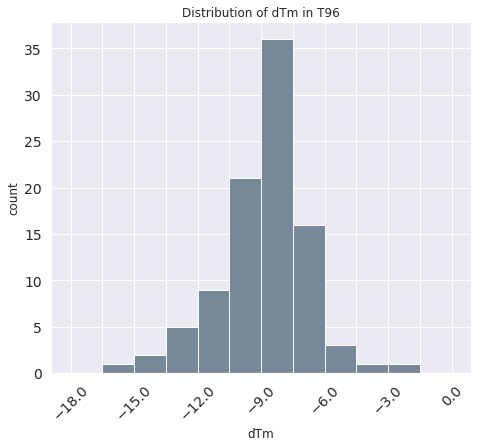

In [0]:
plot_hist_label(pd.Series(y_label),"dTm", "count", "Distribution of dTm in T96", fig_loc+"distribution_of_dTm_96.png")

### Model paper (S_E)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper)

In [0]:
y_pred = model_paper.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  7.713249115700304
Root mean squared error:  8.372833996623418
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std()))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std())))



```
Mean absolute error: 0.8176846045826429
Root mean squared error:  1.0225009188117082
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean()), (y_pred-y_pred.mean())))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean()), (y_pred-y_pred.mean()))))



```
Mean absolute error:  2.642797013094041
Root mean squared error:  3.3514375421418845
```



### Model paper (filtered) (S_E_f) 

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper)

In [0]:
y_pred = model_paper_filtered.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  7.7254565684715315
Root mean squared error:  8.22523892229394
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std()))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std())))



```
Mean absolute error:  0.7732910728949264
Root mean squared error:  0.9897124361050428
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean()), (y_pred-y_pred.mean())))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean()), (y_pred-y_pred.mean()))))



```
Mean absolute error:  2.29932745260391
Root mean squared error:  2.938982649175337
```



### Model seq_rep (A13)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_seq_all_01_02_03)

In [0]:
y_pred = model_seq_rep.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  7.762334454449852
Root mean squared error:  8.100663261274553
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std()))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std())))



```
Mean absolute error:  0.9503006154657673
Root mean squared error:  1.213011776500763
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean()), (y_pred-y_pred.mean())))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean()), (y_pred-y_pred.mean()))))



```
Mean absolute error:  1.7932560534349944
Root mean squared error:  2.316659042618126
```



### Model seq_rep (filtered) (A13_f)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_seq_all_01_02_03)

In [0]:
y_pred = model_seq_rep_filtered.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  6.395609265269756
Root mean squared error:  6.779539435903042
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std()))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std())))



```
Mean absolute error:  0.9486144202031405
Root mean squared error:  1.2424867337728531
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean()), (y_pred-y_pred.mean())))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean()), (y_pred-y_pred.mean()))))



```
Mean absolute error:  1.6821537312790287
Root mean squared error:  2.3144809180679453
```



### Model paper cnn 01 02 03 all (S_E_A13)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper_all_01_02_03)

In [0]:
y_pred = model_combined.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  7.855888818656742
Root mean squared error:  8.173554086940719
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std()))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std())))



```
Mean absolute error:  0.7655567559721753
Root mean squared error:  0.9702954822672316
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean()), (y_pred-y_pred.mean())))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean()), (y_pred-y_pred.mean()))))



```
Mean absolute error:  1.7796896871750356
Root mean squared error:  2.256545420416815
```



### Model paper cnn 01 02 03 all (filtered) (S_E_A13_f)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper_all_01_02_03)

In [0]:
y_pred = model_combined_filtered.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  7.709843436211685
Root mean squared error:  8.014428737324547
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std()))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean())/y_label.std(), (y_pred-y_pred.mean())/y_pred.std())))



```
Mean absolute error:  0.6842052592721258
Root mean squared error:  0.9099268269532382
```



In [0]:
print("Mean absolute error: ",mean_absolute_error((y_label-y_label.mean()), (y_pred-y_pred.mean())))
print("Root mean squared error: ",np.sqrt(mean_squared_error((y_label-y_label.mean()), (y_pred-y_pred.mean()))))



```
Mean absolute error:  1.6468152440469794
Root mean squared error:  2.1884657110634174
```



## Results NEW

### Visualize performance of models

In [0]:
columns = ["MAE","RMSE"]
index = ["S_E", "S_E_f", "A13", "A13_f", "S_E_A13", "S_E_A13_f"]
values = np.array([ [7.713249115700304, 8.372833996623418],
 [7.7254565684715315,8.22523892229394],
 [7.762334454449852,8.100663261274553],
 [6.395609265269756,6.779539435903042],
 [7.855888818656742,8.173554086940719],
 [7.709843436211685,8.014428737324547]])

In [0]:
results_table = pd.DataFrame(values)
results_table.columns = columns
results_table.index = index

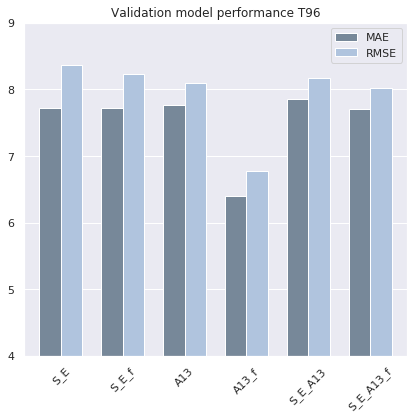

In [0]:
plot_results_bar(results_df=results_table, title="Validation model performance T96", saveloc=fig_loc+"validation_model_performance_T96_NEW.png", fig_size=(6,6), fig_lim=(4,9))

In [0]:
results_table = results_table.round(3)
results_table

,MAE,RMSE
S_E,7.713,8.373
S_E_f,7.725,8.225
A13,7.762,8.101
A13_f,6.396,6.780
S_E_A13,7.856,8.174
S_E_A13_f,7.710,8.014


In [0]:
results_table.to_csv(fig_loc+"retrospective_T96_results_table_NEW.csv")

### Visualize normalized performance of models

In [0]:
columns = ["MAE","RMSE"]
index = ["S_E", "S_E_f", "A13", "A13_f", "S_E_A13", "S_E_A13_f"]
values = np.array([ [2.642797013094041,3.3514375421418845],
 [2.29932745260391,2.938982649175337],
 [1.7932560534349944,2.316659042618126],
 [1.6821537312790287,2.3144809180679453],
 [1.7796896871750356,2.256545420416815],
 [1.6468152440469794,2.1884657110634174]])

In [0]:
results_table = pd.DataFrame(values)
results_table.columns = columns
results_table.index = index

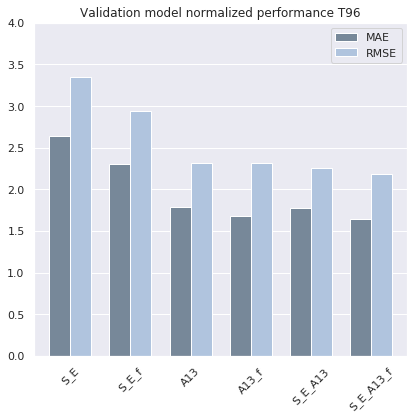

In [0]:
plot_results_bar(results_df=results_table, title="Validation model normalized performance T96", saveloc=fig_loc+"validation_model_normalized_performance_T96_NEW.png", fig_size=(6,6), fig_lim=(0,4))

In [0]:
results_table = results_table.round(3)
results_table

,MAE,RMSE
S_E,2.643,3.351
S_E_f,2.299,2.939
A13,1.793,2.317
A13_f,1.682,2.314
S_E_A13,1.780,2.257
S_E_A13_f,1.647,2.188


In [0]:
results_table.to_csv(fig_loc+"retrospective_T96_normalized_results_table_NEW.csv")

## Perfomance reported by paper NEW:


### Calculate MSE and RMSE:

In [0]:
predictions_reported = T96_table[list(filter(lambda x: "pred" in x, T96_table.columns))]

In [0]:
predictions_reported.head()

,S_pred,L_pred,G_pred,LG_pred,SL_pred,SG_pred,SLG_pred,BL_tiE_pred,BL_tiE_SLG_pred,Cart_tiE_pred,Cart_tiE_SLG_pred,DS_tiE_pred,DS_tiE_SLG_pred,MOE_tiE_pred,MOE_tiE_SLG_pred,Mono_tiE_pred,Mono_tiE_SLG_pred
0,-3.472251,-0.236857,-2.305103,-5.918787,-6.099172,-2.789124,-5.906498,-9.429717,-10.196714,-6.089868,-1.264069,-7.659227,-9.317076,-1.366947,-5.875091,-6.252649,-2.853494
1,-0.296855,0.453156,-1.555240,-1.133960,4.169010,-1.610447,-0.281584,1.129832,1.521148,-3.468148,0.818945,-3.992939,0.596031,-2.747829,0.992325,-1.797963,1.319017
2,0.135458,0.453156,-2.597651,-0.961520,4.186687,0.963719,1.519620,3.598429,4.331543,1.597182,1.051449,0.149311,2.264583,-2.602893,0.080114,-1.047028,1.319300
3,-0.053245,0.453156,1.429155,5.091648,4.907764,2.237467,5.100822,2.562117,6.335236,1.233499,3.727824,-0.168061,4.649483,-2.620306,4.535145,-0.996889,5.133992
4,-1.268235,-0.768563,-6.042488,-2.077006,1.720965,-5.666101,-0.488654,-1.361471,1.863765,-2.536633,1.621084,-1.568452,0.926985,-2.252484,0.710950,-1.377593,0.624818


In [0]:
len(predictions_reported.columns)

17

In [0]:
y_label

array([ -8.6472965,  -9.025969 ,  -6.39141  , -10.608879 ,  -7.898822 ,
        -8.548569 ,  -9.402464 ,  -7.802352 ,  -7.212083 ,  -7.797925 ,
       -10.3890975,  -8.260683 ,  -8.339845 ,  -6.651839 ,  -6.516335 ,
        -8.0932575,  -9.311112 ,  -7.9246425, -10.441612 ,  -8.1014315,
       -10.0117625, -13.351809 , -11.612842 , -12.958954 , -10.163668 ,
        -7.595109 ,  -7.867994 ,  -7.526578 ,  -8.137897 ,  -9.9419415,
        -9.878807 ,  -6.8762075,  -8.981353 , -10.732035 ,  -9.6544935,
        -7.6540025,  -7.8482865,  -6.595135 ,  -7.193516 ,  -8.051651 ,
        -7.922285 ,  -9.1033365, -10.934785 , -10.154803 , -13.751848 ,
       -14.582517 , -10.0827735, -18.9160225, -11.102066 ,  -8.276861 ,
        -9.48827  ,  -8.806894 ,  -5.526265 ,  -7.520885 ,  -8.097206 ,
       -11.122112 ,  -6.3869775,  -6.952863 ,  -9.364774 ,  -9.676138 ,
        -9.624333 ,  -7.1868265,  -8.2825115,  -8.4722775,  -7.5967515,
        -8.807464 ,  -4.3136865,  -7.2266915,  -7.112441 ,  -8.3

In [0]:
model_MAEs = predictions_reported.apply(lambda x: mean_absolute_error(x, y_label), axis=0)

In [0]:
model_RMSEs = predictions_reported.apply(lambda x: np.sqrt(mean_squared_error(x, y_label)), axis=0)

In [0]:
model_normalized_MAEs = predictions_reported.apply(lambda x: mean_absolute_error((x-x.mean()), (y_label-y_label.mean())), axis=0)

In [0]:
model_normalized_RMSEs = predictions_reported.apply(lambda x: np.sqrt(mean_squared_error((x-x.mean()), (y_label-y_label.mean()))), axis=0)

In [0]:
model_z_normalized_MAEs = predictions_reported.apply(lambda x: mean_absolute_error((x-x.mean())/x.std(), (y_label-y_label.mean())/y_label.std()), axis=0)

In [0]:
model_z_normalized_RMSEs = predictions_reported.apply(lambda x: np.sqrt(mean_squared_error((x-x.mean())/x.std(), (y_label-y_label.mean())/y_label.std())), axis=0)

In [0]:
model_MAEs

S_pred                7.673313
L_pred                7.504214
G_pred                5.862454
LG_pred               7.490822
SL_pred              10.040901
SG_pred               6.708980
SLG_pred              8.678314
BL_tiE_pred           7.800017
BL_tiE_SLG_pred       9.023503
Cart_tiE_pred         7.843610
Cart_tiE_SLG_pred     9.612030
DS_tiE_pred           7.002898
DS_tiE_SLG_pred       8.299226
MOE_tiE_pred          8.634071
MOE_tiE_SLG_pred      9.365468
Mono_tiE_pred         7.553365
Mono_tiE_SLG_pred     9.173066
dtype: float64

In [0]:
model_normalized_MAEs

S_pred               1.948323
L_pred               1.850547
G_pred               2.239948
LG_pred              2.010067
SL_pred              2.227464
SG_pred              2.145907
SLG_pred             2.219289
BL_tiE_pred          2.452937
BL_tiE_SLG_pred      2.838755
Cart_tiE_pred        1.973971
Cart_tiE_SLG_pred    1.882683
DS_tiE_pred          2.040926
DS_tiE_SLG_pred      2.192158
MOE_tiE_pred         2.795252
MOE_tiE_SLG_pred     2.878962
Mono_tiE_pred        1.752202
Mono_tiE_SLG_pred    2.079446
dtype: float64

In [0]:
model_z_normalized_MAEs

S_pred               0.916245
L_pred               0.859684
G_pred               1.024754
LG_pred              0.822574
SL_pred              0.847318
SG_pred              0.909421
SLG_pred             0.796304
BL_tiE_pred          0.929072
BL_tiE_SLG_pred      0.868319
Cart_tiE_pred        0.764080
Cart_tiE_SLG_pred    0.917539
DS_tiE_pred          0.985376
DS_tiE_SLG_pred      0.830027
MOE_tiE_pred         1.143232
MOE_tiE_SLG_pred     0.903886
Mono_tiE_pred        0.751464
Mono_tiE_SLG_pred    0.921992
dtype: float64

### Visualize normalized performance of reported paper models

In [0]:
model_normalized_MAEs

S_pred               1.948323
L_pred               1.850547
G_pred               2.239948
LG_pred              2.010067
SL_pred              2.227464
SG_pred              2.145907
SLG_pred             2.219289
BL_tiE_pred          2.452937
BL_tiE_SLG_pred      2.838755
Cart_tiE_pred        1.973971
Cart_tiE_SLG_pred    1.882683
DS_tiE_pred          2.040926
DS_tiE_SLG_pred      2.192158
MOE_tiE_pred         2.795252
MOE_tiE_SLG_pred     2.878962
Mono_tiE_pred        1.752202
Mono_tiE_SLG_pred    2.079446
dtype: float64

In [0]:
model_normalized_RMSEs

S_pred               2.543297
L_pred               2.506262
G_pred               2.885529
LG_pred              2.758081
SL_pred              2.965871
SG_pred              2.721479
SLG_pred             2.995002
BL_tiE_pred          3.212732
BL_tiE_SLG_pred      3.657908
Cart_tiE_pred        2.536418
Cart_tiE_SLG_pred    2.472535
DS_tiE_pred          2.753291
DS_tiE_SLG_pred      2.866034
MOE_tiE_pred         3.372294
MOE_tiE_SLG_pred     3.645668
Mono_tiE_pred        2.323527
Mono_tiE_SLG_pred    2.632376
dtype: float64

In [0]:
columns = ["MAE","RMSE"]
index = ["BL", "CART", "DS", "MOE", "MONO"]
values = np.array([ [2.452937,3.212732],
 [ 1.973971,2.536418],
 [2.040926,2.753291],
 [2.795252,3.372294],
 [1.752202,2.323527]])

In [0]:
results_table = pd.DataFrame(values)
results_table.columns = columns
results_table.index = index

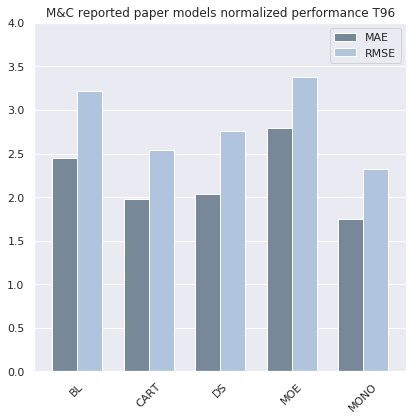

In [0]:
plot_results_bar(results_df=results_table, title="M&C reported paper models normalized performance T96", saveloc=fig_loc+"m&c_reported_paper_models_normalized_performance_T96_NEW.png", fig_size=(6,6), fig_lim=(0,4))

In [0]:
results_table = results_table.round(3)
results_table

,MAE,RMSE
BL,2.453,3.213
CART,1.974,2.536
DS,2.041,2.753
MOE,2.795,3.372
MONO,1.752,2.324


In [0]:
results_table.to_csv(fig_loc+"m&c_reported_paper_models_retrospective_T96_normalized_results_table_NEW.csv")

## Visualize perfomace depending on mutations seen:

Model is traned on T1626, however, progressively more and more datapoints from T96 are inserted into the training set, which wich the model is then retrained, to see the effect on model performance.

In [0]:
training_steps = list(range(0,6,1))+list(range(7,16,2))+list(range(18,31,3))+list(range(35,56,5))
training_steps

[0, 1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55]

In [0]:
result = train_with_additional_sequences(X_T1626, X_paper, y_T1626, y_label, training_steps, parameter_table_paper)

Default training set size: 1626
Max additional training set size: 55
Validation set size: 41


In [0]:
result.to_csv(fig_loc+"performance_dependent_on_mutations_seen_T96_model_paper.csv")

In [0]:
result = pd.read_csv(fig_loc+"performance_dependent_on_mutations_seen_T96_model_paper.csv")

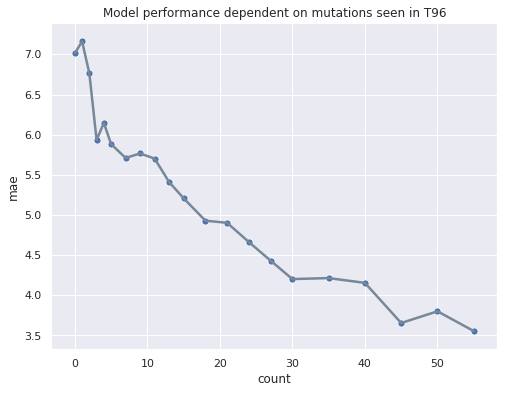

In [0]:
sns.set()
pylab.rc('font', family="Sans", size=16)
sns.set(rc={'figure.figsize':(8,6)})
sns.lineplot(x="count", y="mae", legend="full", data=result, linewidth=2.5, color="lightslategray").set_title('Model performance dependent on mutations seen in T96')
sns.scatterplot(x="count", y="mae", data=result, s=50);
plt.savefig(fig_loc+"performance_dependent_on_mutations_seen_T96_model_paper.png", dpi=300)